# **Brain Tumour Classification through MRI Images Using Deep Learning**  

## **1.Introduction**  

* The occurrence of brain tumor patients in India is steadily rising,
more and more number of cases are reported each year in India across
various age groups.  


## **2. Setting Up Local Storage for Dataset**

### **2.1 Giving Access To Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


### **2.2 Checking OS Version and Details**

In [7]:
print("OS Version & Details: ")
!lsb_release -a

OS Version & Details: 
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.4 LTS
Release:	22.04
Codename:	jammy


## **3. Importing Required Libraries**

In [8]:
import sys
import os
import math

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import *

print(f'Tensorflow Version: {tf.__version__}.')

Tensorflow Version: 2.18.0.


## **4. Setting Up the Environment**

In [11]:
gpu_device_location = tpu_device_location = cpu_device_location = None

if os.environ['COLAB_GPU'] == '1':
    print("Allocated GPU Runtime Details:")
    !nvidia-smi
    print()
    try:
        import pynvml
        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        gpu_device_name = pynvml.nvmlDeviceGetName(handle)

        if gpu_device_name not in {b'Tesla T4', b'Tesla P4', b'Tesla P100-PCIE-16GB'}:
            raise Exception("Unfortunately this instance does not have a T4, P4 or P100 GPU.\nSometimes Colab allocates a Tesla K80 instead of a T4, P4 or P100.\nIf you get Tesla K80 then you can factory reset your runtime to get another GPUs.")
    except Exception as hardware_exception:
        print(hardware_exception, end = '\n\n')
    gpu_device_location = tf.test.gpu_device_name()
    print(f"{gpu_device_name} is allocated successfully at location: {gpu_device_location}")
elif 'COLAB_TPU_ADDR' in os.environ:
    tpu_device_location = f"grpc://{os.environ['COLAB_TPU_ADDR']}"
    print(f"TPU is allocated successfully at location: {tpu_device_location}.")
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_location)
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    tpu_strategy = tf.distribute.TPUStrategy()
else:
    cpu_device_location = "/cpu:0"
    print("GPUs and TPUs are not allocated successfully, hence runtime fallbacked to CPU.")

Allocated GPU Runtime Details:
Thu Jul 24 12:47:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P0             29W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------

## **5. Data Preprocessing and Exploratory Data Analysis**

In [16]:
import os
import pandas as pd

# Define folder paths directly
meningioma_path = "/content/gdrive/MyDrive/Brain Tumour/train/meningioma"
glioma_path = "/content/gdrive/MyDrive/Brain Tumour/train/glioma"
pituitary_path = "/content/gdrive/MyDrive/Brain Tumour/train/pituitary"
no_tumor_path = "/content/gdrive/MyDrive/Brain Tumour/train/no_tumor"

# Count images in each folder
data_distribution_count = pd.Series({
    'meningioma': len(os.listdir(meningioma_path)),
    'glioma': len(os.listdir(glioma_path)),
    'pituitary_tumor': len(os.listdir(pituitary_path)),
    'no_tumor': len(os.listdir(no_tumor_path))
})

# Show the counts
print(data_distribution_count)

meningioma         388
glioma             599
pituitary_tumor    468
no_tumor           353
dtype: int64


### **5.1 Data Distribution Visualization**

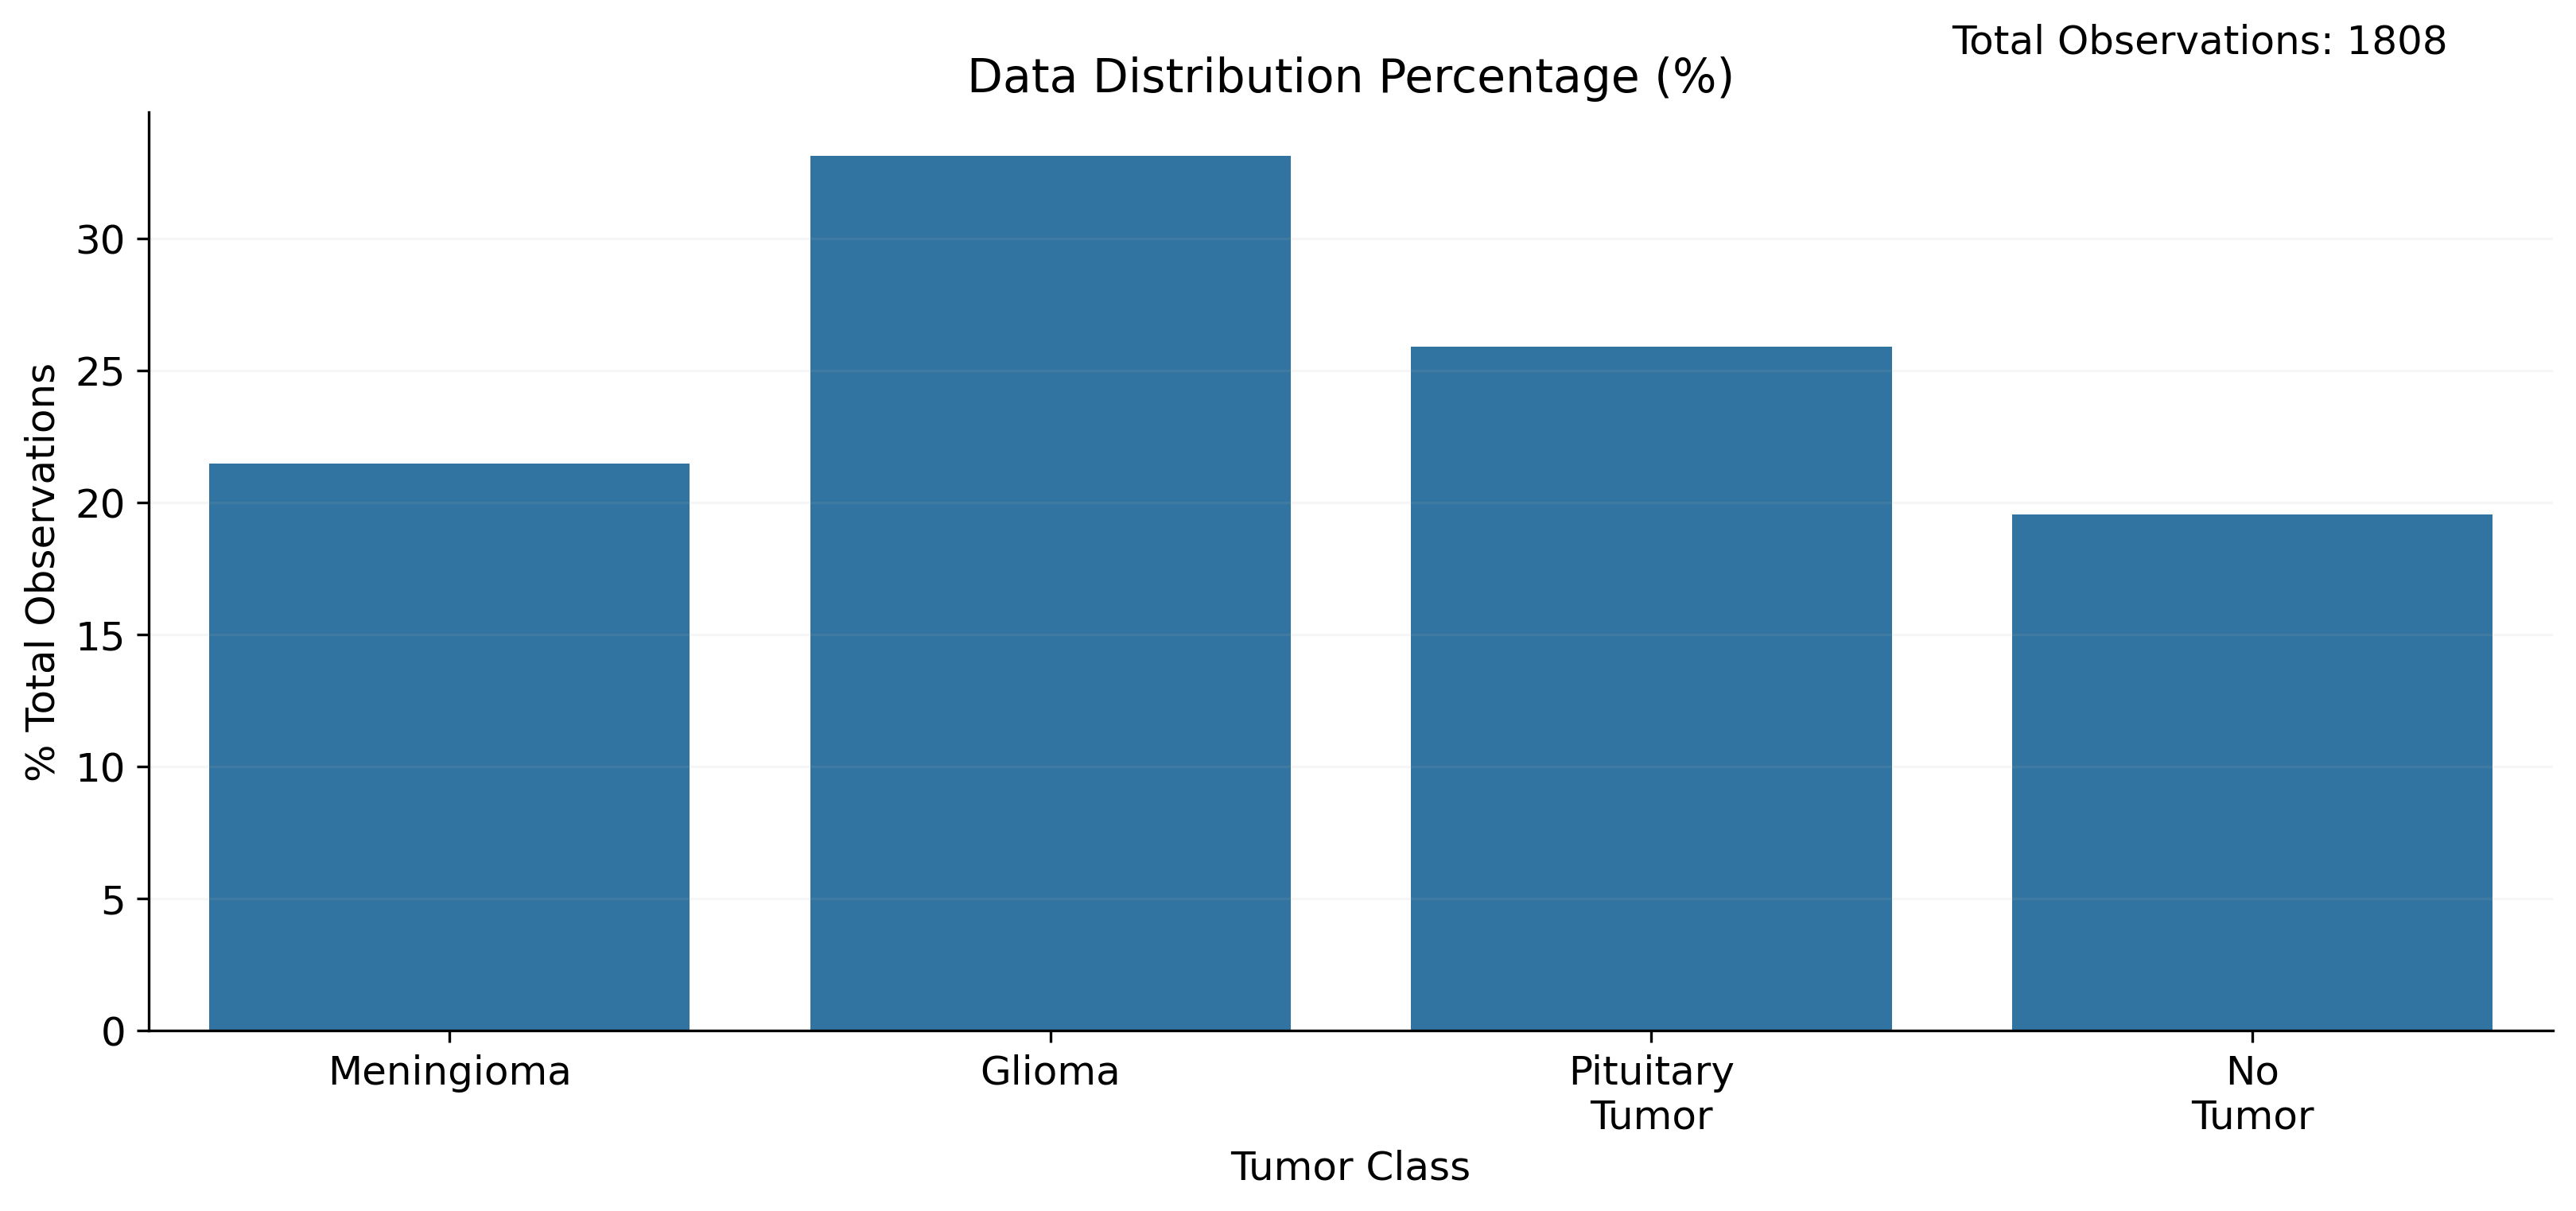

In [17]:
fig, axis = plt.subplots(figsize = (13, 5))
axis.grid(True, alpha = 0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize = 14)
sns.barplot(x = ['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y = 100 * (data_distribution_count / data_distribution_count.sum()), ax = axis)
axis.set_xlabel("Tumor Class", fontsize = 12)
axis.set_ylabel("% Total Observations", fontsize = 12)
axis.tick_params(which = 'major', labelsize = 12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict = dict(size = 12))
sns.despine()

### **5.2 Visualisation of Brain MRI Dataset**

**Dataset Source: https://figshare.com/articles/dataset/brain_tumor_dataset/1512427**  

**Source Code for Conversion of `.mat` file to `.jpg`: [Google Colab Notebook Link](https://colab.research.google.com/drive/1aucu3Ipj1eS0y1YEzKq76Z38TaetHSc3?usp=sharing)**  

**Final Dataset Link: https://drive.google.com/drive/folders/11QIC82FBdAyq0PUwLVNd22i-oq6lcat1?usp=sharing**

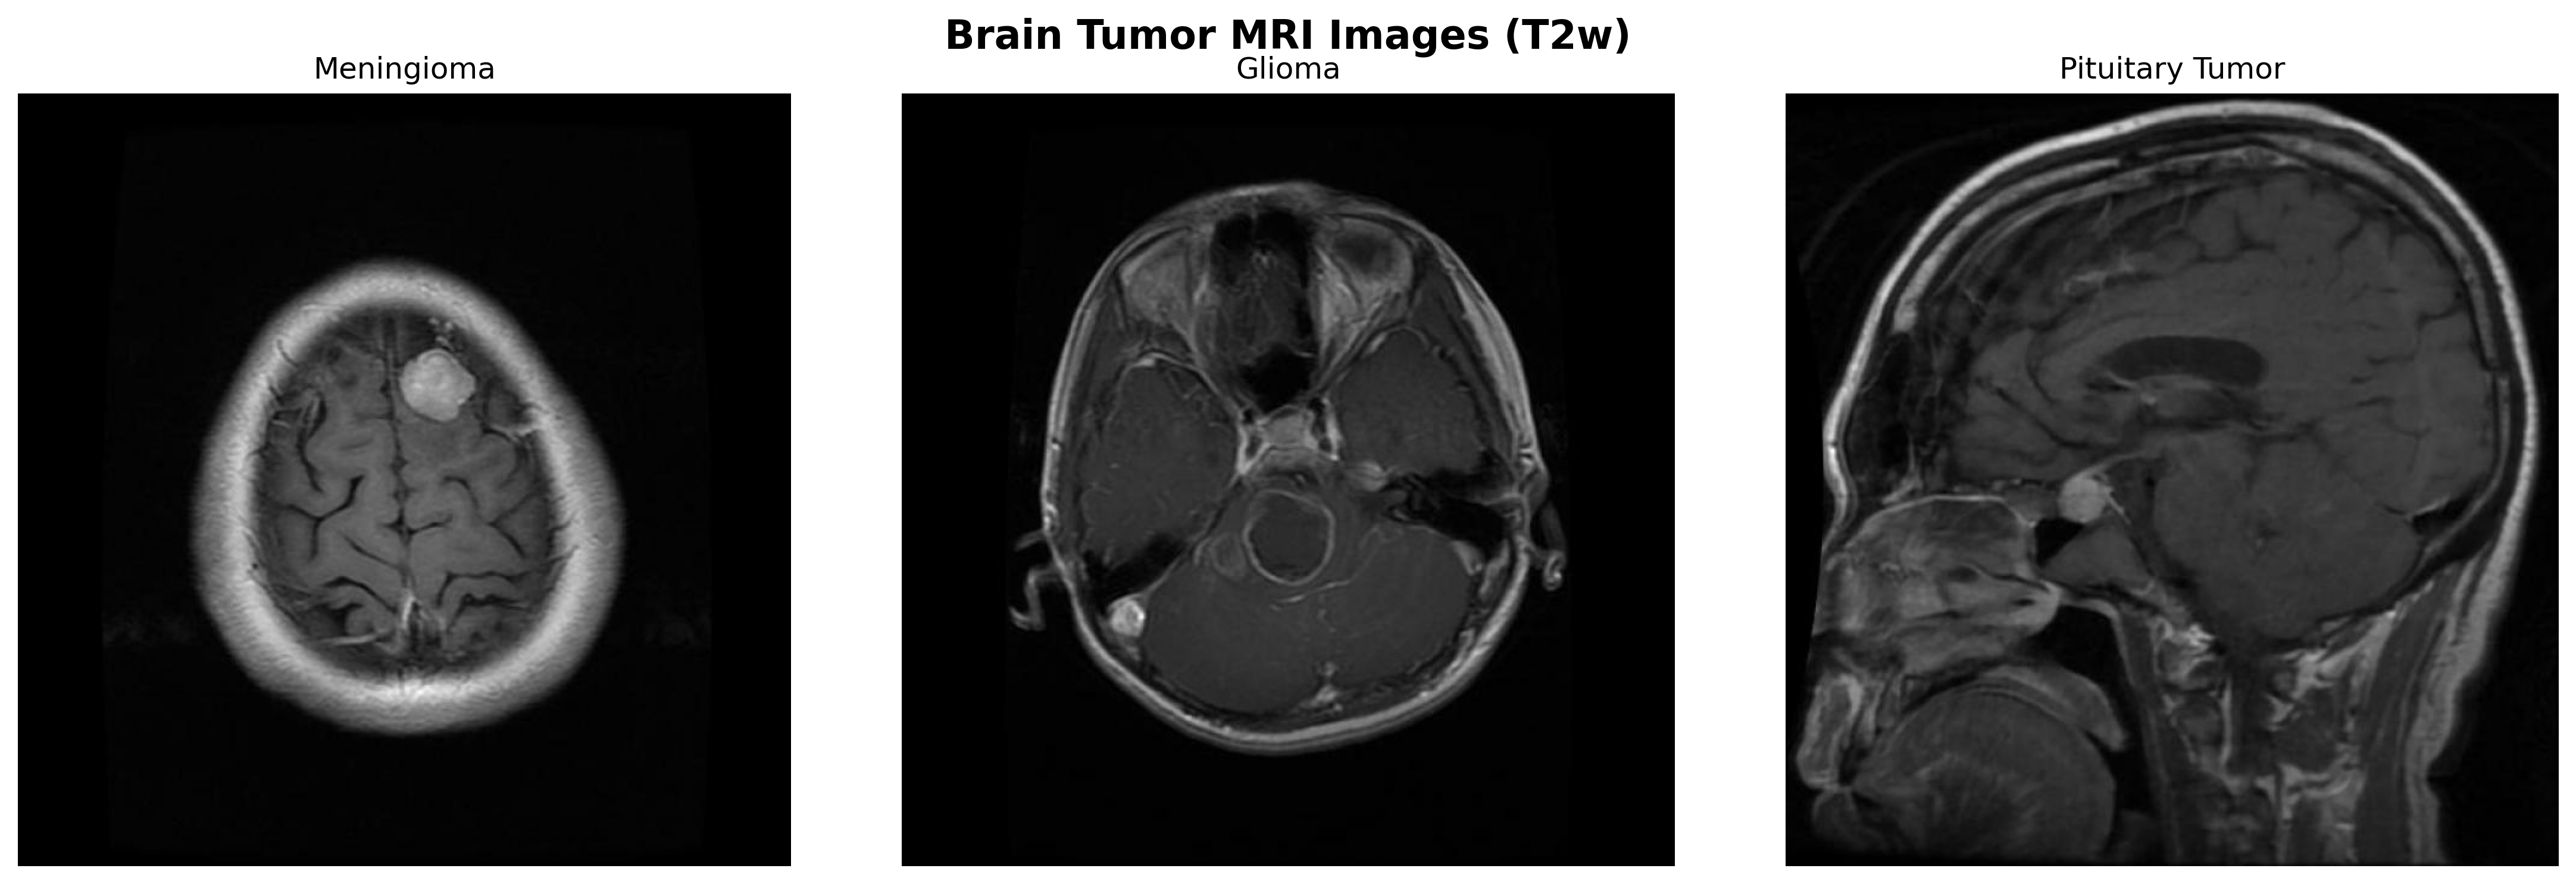

In [21]:
import matplotlib.pyplot as plt
import cv2
import os

# Set the path to each class folder
image_paths = {
    "Meningioma": "/content/gdrive/MyDrive/Brain Tumour/train/meningioma",
    "Glioma": "/content/gdrive/MyDrive/Brain Tumour/train/glioma",
    "Pituitary Tumor": "/content/gdrive/MyDrive/Brain Tumour/train/pituitary"
}

# Create subplots - 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Brain Tumor MRI Images (T2w)", fontsize=16, fontweight="bold")

# Loop through classes and display one image from each
for ax, (label, path) in zip(axes, image_paths.items()):
    image_file = os.listdir(path)[0]  # Just take the first image
    img = cv2.imread(os.path.join(path, image_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

### **6. Development of Training, Validation & Testing Dataset**

In [25]:
import os

# Define base path
BASE_PATH = "/content/gdrive/MyDrive/Brain Tumour/train"

# Define tumor class folder names
TUMOR_CLASS = ["glioma", "meningioma", "pituitary", "no_tumor"]

# Create image data paths
IMAGE_DATA_PATHS = [os.path.join(BASE_PATH, cls) for cls in TUMOR_CLASS]

# Now extract all (image_path, class_label) pairs
image_data_paths = [
    (os.path.join(curr_path, filename), tumor_name)
    for curr_path, tumor_name in zip(IMAGE_DATA_PATHS, TUMOR_CLASS)
    if os.path.isdir(curr_path)
    for filename in os.listdir(curr_path)
]

In [27]:
import pandas as pd
df = pd.DataFrame(image_data_paths, columns=["image_path", "label"])
df.head()

,image_path,label
0,/content/gdrive/MyDrive/Brain Tumour/train/gli...,glioma
1,/content/gdrive/MyDrive/Brain Tumour/train/gli...,glioma
2,/content/gdrive/MyDrive/Brain Tumour/train/gli...,glioma
3,/content/gdrive/MyDrive/Brain Tumour/train/gli...,glioma
4,/content/gdrive/MyDrive/Brain Tumour/train/gli...,glioma


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1808 entries, 0 to 1807
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  1808 non-null   object
 1   label       1808 non-null   object
dtypes: object(2)
memory usage: 28.4+ KB


In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Convert to DataFrame
df = pd.DataFrame(image_data_paths, columns=["image_path", "tumor_class"])

# Step 2: First split — train + val vs test (70-30)
intermediate_train_data, test_data = train_test_split(
    df,
    train_size=0.70,
    random_state=42,
    stratify=df["tumor_class"]
)

# Step 3: Split train into train + val (80-20 of the 70%)
train_data, validation_data = train_test_split(
    intermediate_train_data,
    train_size=0.80,
    random_state=42,
    stratify=intermediate_train_data["tumor_class"]
)

### **6.1 Training, Validation and Testing Dataset Data Distribution Visualization**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Total images found: 1808
                                          image_path tumor_class
0  /content/drive/MyDrive/Brain Tumour/train/glio...      glioma
1  /content/drive/MyDrive/Brain Tumour/train/glio...      glioma
2  /content/drive/MyDrive/Brain Tumour/train/glio...      glioma
3  /content/drive/MyDrive/Brain Tumour/train/glio...      glioma
4  /content/drive/MyDrive/Brain Tumour/train/glio...      glioma
tumor_class
glioma        599
pituitary     468
meningioma    388
no_tumor      353
Name: count, dtype: int64
Train size: 1012
Validation size: 253
Test size: 543


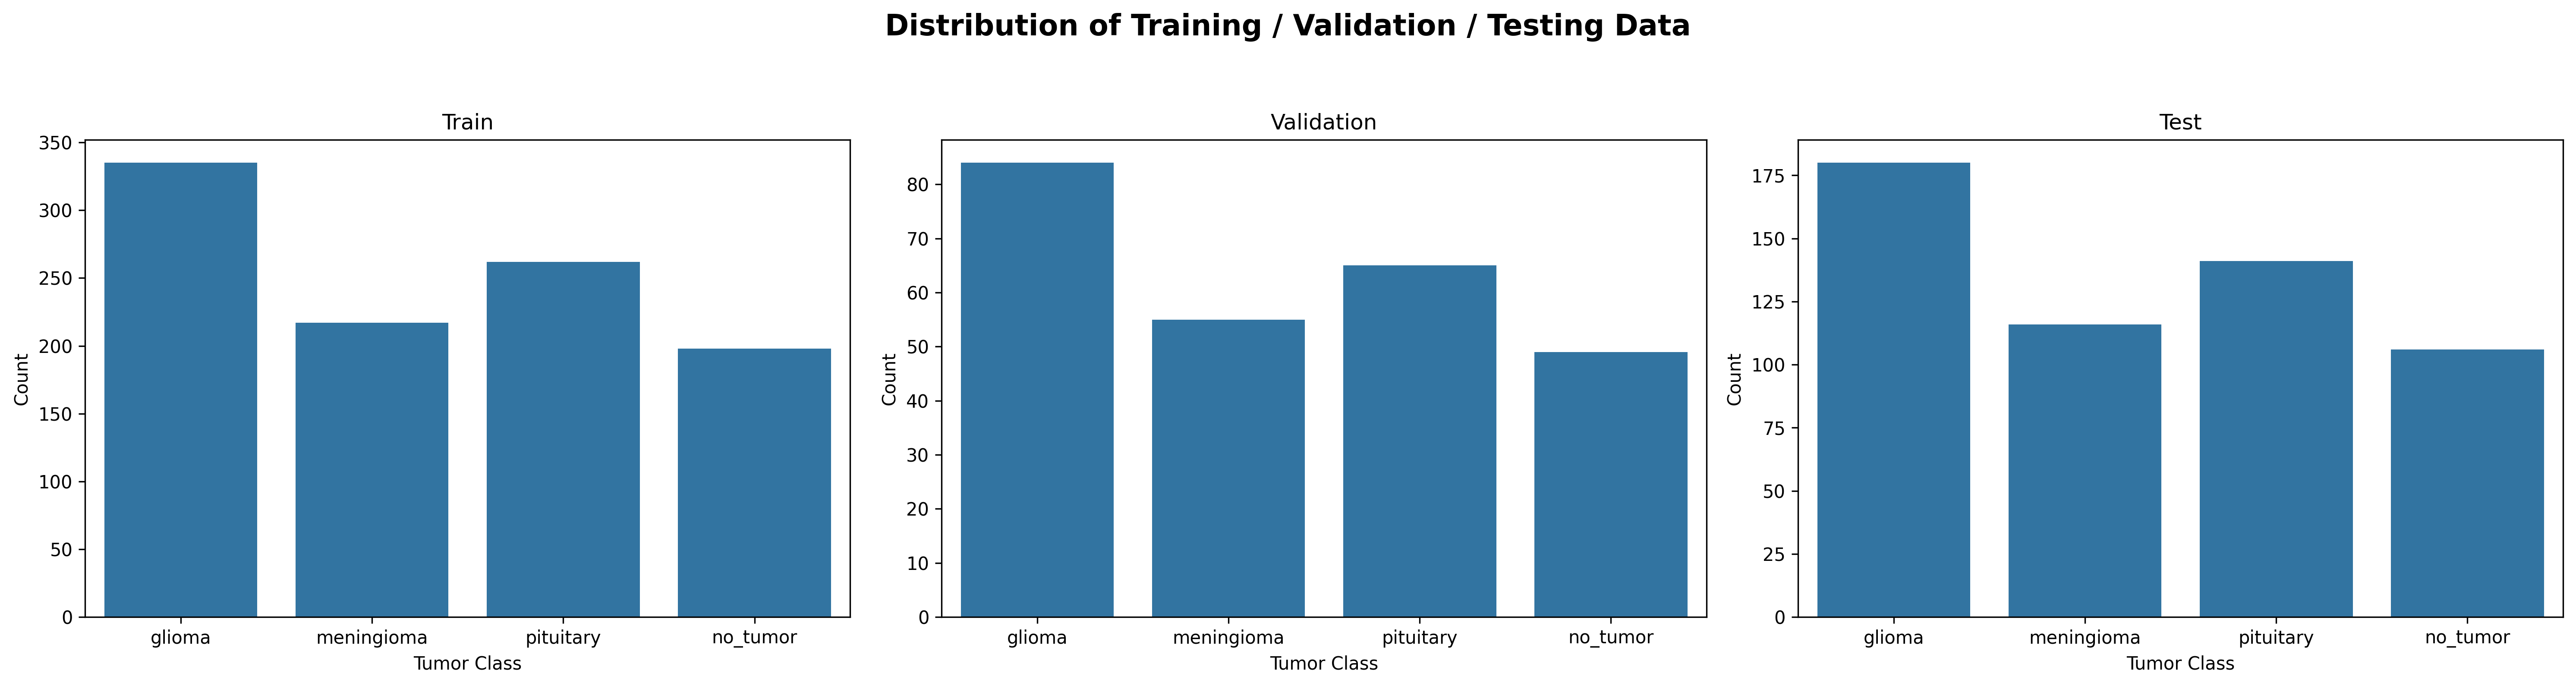

In [36]:
# --- Imports ---
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Tumor Classes ---
TUMOR_CLASS = ['glioma', 'meningioma', 'pituitary', 'no_tumor']

# --- Dataset Root ---
DATA_ROOT = "/content/drive/MyDrive/Brain Tumour"

# --- Folder paths for each class under train ---
IMAGE_DATA_PATHS = [os.path.join(DATA_ROOT, 'train', cls) for cls in TUMOR_CLASS]

# --- Load image paths into dataframe ---
image_data_paths = []

for curr_path, tumor_name in zip(IMAGE_DATA_PATHS, TUMOR_CLASS):
    if os.path.exists(curr_path) and os.path.isdir(curr_path):
        for filename in os.listdir(curr_path):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(curr_path, filename)
                image_data_paths.append((full_path, tumor_name))

print(f"✅ Total images found: {len(image_data_paths)}")

# --- Create dataframe ---
image_df = pd.DataFrame(image_data_paths, columns=["image_path", "tumor_class"])

# --- Sanity check ---
print(image_df.head())
print(image_df['tumor_class'].value_counts())

# --- Train/Val/Test Split ---
intermediate_train_data, test_data = train_test_split(
    image_df,
    train_size=0.70,
    stratify=image_df['tumor_class'],
    random_state=42
)

train_data, validation_data = train_test_split(
    intermediate_train_data,
    train_size=0.80,
    stratify=intermediate_train_data['tumor_class'],
    random_state=42
)

print("Train size:", len(train_data))
print("Validation size:", len(validation_data))
print("Test size:", len(test_data))

# --- Plot Class Distribution ---
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
fig.suptitle("Distribution of Training / Validation / Testing Data", fontsize=16, weight='bold', y=1.05)

sns.countplot(x=train_data.tumor_class, order=TUMOR_CLASS, ax=axes[0])
axes[0].set_title("Train")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Tumor Class")

sns.countplot(x=validation_data.tumor_class, order=TUMOR_CLASS, ax=axes[1])
axes[1].set_title("Validation")
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Tumor Class")

sns.countplot(x=test_data.tumor_class, order=TUMOR_CLASS, ax=axes[2])
axes[2].set_title("Test")
axes[2].set_ylabel("Count")
axes[2].set_xlabel("Tumor Class")

plt.tight_layout()
plt.show()

## **7. Data/Image Augmentation**
* Image augmentation is usually used to increase the image dataset and also to make the network more robust against translation invariance. Image augmentation is defined as creating duplicates of the original image datasets by flipping, rotating, zooming, and adjusting brightness.

* We will use data/image augmentation using `ImageDataGenerator` class to train the model on different types of combinations formed by rotation, flipping, changing the brightness etc of an image so as to increase our model accuracy.

In [37]:
image_size = 128
batch_size = 32

image_datagen_kwargs = dict(rescale = 1 / 255,
                            rotation_range = 15,
                            width_shift_range = 0.1,
                            zoom_range = 0.01,
                            shear_range = 0.01,
                            brightness_range = [0.3, 1.5],
                            horizontal_flip = True,
                            vertical_flip = True)

In [38]:
train_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
validation_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
test_image_datagen = ImageDataGenerator(**image_datagen_kwargs)

In [40]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data,
                                                        x_col = 'image_path',
                                                        y_col = 'tumor_class',
                                                        seed = 42,
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')
validation_dataset = validation_image_datagen.flow_from_dataframe(validation_data,
                                                                  x_col = 'image_path',
                                                                  y_col = 'tumor_class',
                                                                  seed = 42,
                                                                  batch_size = batch_size,
                                                                  target_size = (image_size, image_size),
                                                                  color_mode = 'rgb')
test_dataset = test_image_datagen.flow_from_dataframe(test_data,
                                                      x_col = 'image_path',
                                                      y_col = 'tumor_class',
                                                      seed = 42,
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

Found 1012 validated image filenames belonging to 4 classes.
Found 253 validated image filenames belonging to 4 classes.
Found 543 validated image filenames belonging to 4 classes.


In [44]:
print("Information about Training Dataset:")
print(train_dataset.class_indices)
print(train_dataset.image_shape, end = '\n\n')

print("Information about Validation Dataset:")
print(validation_dataset.class_indices)
print(validation_dataset.image_shape, end = '\n\n')

print("Information about Testing Dataset:")
print(test_dataset.class_indices)
print(test_dataset.image_shape)

Information about Training Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
(128, 128, 3)

Information about Validation Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
(128, 128, 3)

Information about Testing Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
(128, 128, 3)


### **7.2 Validation Data Images Glimpse**

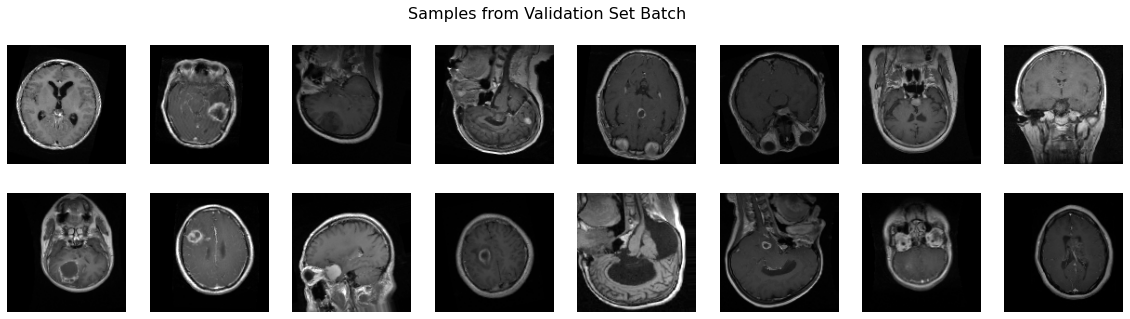

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Validation Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), validation_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

### **7.3 Testing Data Images Glimpse**

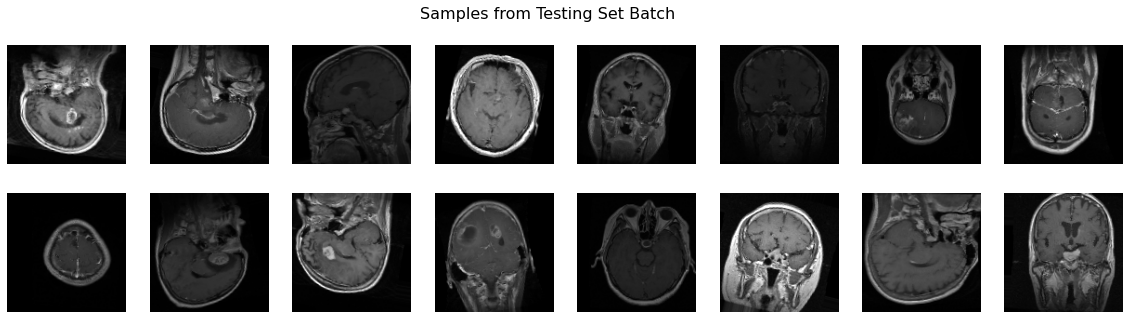

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Testing Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), test_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

## **8. Model Development**

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10)

In [ ]:
ROOT_CHECKPOINT_DIR_PATH = os.path.join(ROOT_DIR, "Model-Checkpoints")
MLP_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "Multi-Layer-Perceptron")
ALEXNET_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "AlexNet-CNN")
INCEPTIONV3_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "InceptionV3")
assert os.path.isdir(ROOT_CHECKPOINT_DIR_PATH) and os.path.isdir(MLP_CHECKPOINT_DIR_PATH) and os.path.isdir(ALEXNET_CHECKPOINT_DIR_PATH) and os.path.isdir(INCEPTIONV3_CHECKPOINT_DIR_PATH)

In [ ]:
mlp_cp_callback = ModelCheckpoint(MLP_CHECKPOINT_DIR_PATH,
                                  monitor = 'val_accuracy',
                                  verbose = 1,
                                  save_weights_only = True,
                                  save_freq =  'epoch')

alexnet_cp_callback = ModelCheckpoint(ALEXNET_CHECKPOINT_DIR_PATH,
                                      monitor = 'val_accuracy',
                                      verbose = 1,
                                      save_weights_only = True,
                                      save_freq = 'epoch')

inceptionv3_cp_callback = ModelCheckpoint(INCEPTIONV3_CHECKPOINT_DIR_PATH,
                                          monitor = 'val_accuracy',
                                          verbose = 1,
                                          save_weights_only = True,
                                          save_freq = 'epoch')

In [ ]:
def training_process_viz(training_stats: pd.DataFrame, **plot_kwargs) -> None:
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    fig.suptitle(plot_kwargs['plot_title'], fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.08)
    for curr_axis, col_name in zip(axes, ['accuracy', 'loss']):
        curr_axis.grid(True, alpha = 0.3)
        curr_axis.set_title(f"Model {col_name}".title(), fontsize = 14)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[col_name], color = 'blue', ax = curr_axis)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[f"val_{col_name}"], color = 'red', ax = curr_axis)
        curr_axis.set_xlabel("Epochs", fontsize = 12)
        curr_axis.set_ylabel(col_name.title(), fontsize = 12)
        curr_axis.tick_params(which = 'major', labelsize = 12)
        curr_axis.legend([col_name.title(), f"validation {col_name}".title()], title = col_name.title())
    fig.tight_layout()
    sns.despine()

In [ ]:
def confusion_matrix_viz(model, test_dataset, **plot_kwargs) -> None:
    assert isinstance(model, Sequential)
    model_preds = [np.argmax(curr_row) for curr_row in model.predict(test_dataset)]
    fig, axis = plt.subplots(figsize = (8, 6))
    class_names = ['Glioma', 'Meningioma', 'No-Tumor', 'Pituitary\nTumor']
    sns.heatmap(confusion_matrix(test_dataset.classes, model_preds), annot = True, cmap = plt.cm.Reds, ax = axis)
    axis.set_title(plot_kwargs['plot_title'], fontsize = 14)
    axis.tick_params(which = 'major', labelsize = 12)
    axis.set_xlabel("Pedicted Class", fontsize = 12)
    axis.set_ylabel("Actual Class", fontsize = 12)
    axis.set_xticklabels(class_names, fontdict = dict(fontsize = 12))
    axis.set_yticklabels(class_names, fontdict = dict(fontsize = 12))
    fig.tight_layout()
    sns.despine()

In [ ]:
def generate_report(*models, test_dataset, row_indexes) -> pd.DataFrame:
    assert len(models)
    report_df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE', 'Loss', 'Accuracy', 'F1-Score'])
    y_hat = test_dataset.classes # y_hat = ground_truth
    for curr_index, curr_model in enumerate(models):
        assert isinstance(curr_model, Sequential)
        curr_model_loss, curr_model_accuracy = curr_model.evaluate(test_dataset)
        y_preds = [np.argmax(curr_preds) for curr_preds in curr_model.predict(test_dataset)]
        report_df.loc[curr_index] = [mean_absolute_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds, squared = False), curr_model_loss, curr_model_accuracy, f1_score(y_hat, y_preds, average = "micro")]
    report_df.index = row_indexes
    return report_df

### **8.1 Multi-Layer Perceptron**

#### **8.1.1 Development of Multi-Layer Perceptron Model**

In [ ]:
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape = (image_size, image_size, 3), name = 'Flatten-Layer'))
mlp_model.add(Dense(2048, activation = 'relu', name = 'Hidden-Layer-1'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-1'))
mlp_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-2'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-2'))
mlp_model.add(Dense(512, activation = 'relu', name = 'Hidden-Layer-3'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-3'))
mlp_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer-1'))
mlp_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten-Layer (Flatten)      (None, 49152)             0         
_________________________________________________________________
Hidden-Layer-1 (Dense)       (None, 2048)              100665344 
_________________________________________________________________
Dropout-Layer-1 (Dropout)    (None, 2048)              0         
_________________________________________________________________
Hidden-Layer-2 (Dense)       (None, 1024)              2098176   
_________________________________________________________________
Dropout-Layer-2 (Dropout)    (None, 1024)              0         
_________________________________________________________________
Hidden-Layer-3 (Dense)       (None, 512)               524800    
_________________________________________________________________
Dropout-Layer-3 (Dropout)    (None, 512)               0

#### **8.1.2 Training and Validation of Multi-Layer Perceptron Based Model**

In [ ]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    mlp_train_history = mlp_model.fit(train_dataset,
                                      batch_size = batch_size,
                                      validation_data = validation_dataset,
                                      epochs = 100,
                                      callbacks = [early_stopping])

Epoch 1/100
61/61 [==============================] - 847s 14s/step - loss: 4.7656 - accuracy: 0.3957 - val_loss: 1.3696 - val_accuracy: 0.3299
Epoch 2/100
61/61 [==============================] - 77s 1s/step - loss: 1.2743 - accuracy: 0.4917 - val_loss: 1.1744 - val_accuracy: 0.5629
Epoch 3/100
61/61 [==============================] - 75s 1s/step - loss: 1.1763 - accuracy: 0.5243 - val_loss: 1.1415 - val_accuracy: 0.5505
Epoch 4/100
61/61 [==============================] - 74s 1s/step - loss: 1.1731 - accuracy: 0.5232 - val_loss: 1.1290 - val_accuracy: 0.5670
Epoch 5/100
61/61 [==============================] - 74s 1s/step - loss: 1.1487 - accuracy: 0.5320 - val_loss: 1.1370 - val_accuracy: 0.5423
Epoch 6/100
61/61 [==============================] - 74s 1s/step - loss: 1.1226 - accuracy: 0.5579 - val_loss: 1.1002 - val_accuracy: 0.5773
Epoch 7/100
61/61 [==============================] - 74s 1s/step - loss: 1.1489 - accuracy: 0.5403 - val_loss: 1.1865 - val_accuracy: 0.5423
Epoch 8/100

#### **8.1.3 Multi-Layer Perceptron Based Model Training Process Statistics**

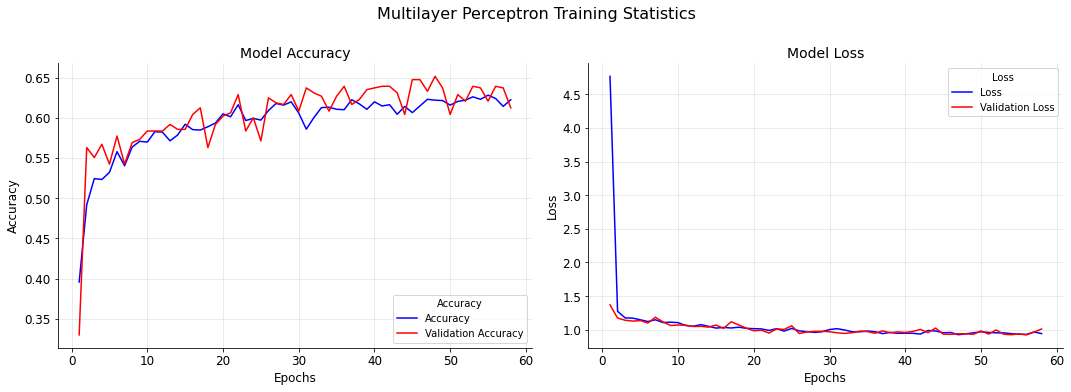

In [ ]:
training_process_viz(pd.DataFrame(mlp_train_history.history),
                     plot_title = 'Multilayer Perceptron Training Statistics')

#### **8.1.4 Confusion Matrix for Multi-Layer Perceptron Based Model**

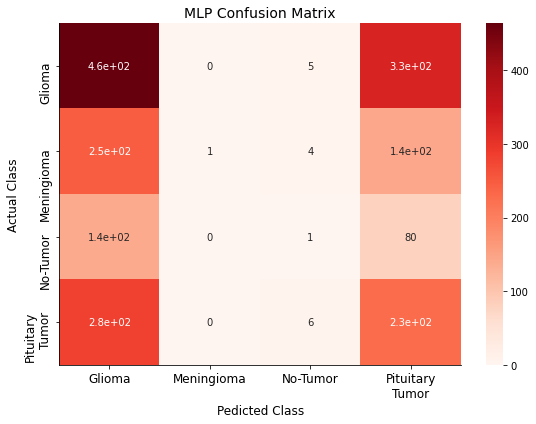

In [ ]:
confusion_matrix_viz(mlp_model, train_dataset, plot_title = "MLP Confusion Matrix")

In [ ]:
mlp_report_df = generate_report(mlp_model,
                                test_dataset = test_dataset,
                                row_indexes = ("Multi-Layer-Perceptron Model",))
mlp_report_df

33/33 [==============================] - 33s 991ms/step - loss: 0.9263 - accuracy: 0.6243


,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
Multi-Layer-Perceptron Model,1.39499,3.533719,1.879819,0.926313,0.624277,0.368979


### **8.2 AlexNet CNN**

#### **8.2.1 Develoment of AlexNet CNN Model**

In [ ]:
alexnet_cnn = Sequential()
alexnet_cnn.add(Conv2D(96, kernel_size = 11, strides = 4, activation = 'relu', input_shape = (image_size, image_size, 3), name = 'Conv2D-1'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-1'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-1'))
alexnet_cnn.add(Conv2D(256, kernel_size = 5, padding = 'same', activation = 'relu', name = 'Conv2D-2'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-2'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-2'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-3'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-3'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-4'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-4'))
alexnet_cnn.add(Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-5'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-5'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-3'))
alexnet_cnn.add(Flatten(name = 'Flatten-Layer-1'))
alexnet_cnn.add(Dense(128, activation = 'relu', name = 'Hidden-Layer-1'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-1'))
alexnet_cnn.add(Dense(64, activation = 'relu', name = 'Hidden-Layer-2'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-2'))
alexnet_cnn.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
alexnet_cnn.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
alexnet_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D-1 (Conv2D)            (None, 30, 30, 96)        34944     
_________________________________________________________________
Batch-Normalization-1 (Batch (None, 30, 30, 96)        384       
_________________________________________________________________
Max-Pooling-1 (MaxPooling2D) (None, 14, 14, 96)        0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 14, 14, 256)       614656    
_________________________________________________________________
Batch-Normalization-2 (Batch (None, 14, 14, 256)       1024      
_________________________________________________________________
Max-Pooling-2 (MaxPooling2D) (None, 6, 6, 256)         0         
_________________________________________________________________
Conv2D-3 (Conv2D)            (None, 6, 6, 384)        

#### **8.2.2 Training and Validation of AlexNet CNN Model**

In [ ]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    alexnet_train_history = alexnet_cnn.fit(train_dataset,
                                            batch_size = batch_size,
                                            validation_data = validation_dataset,
                                            epochs = 100,
                                            callbacks = [early_stopping, alexnet_cp_callback])

Epoch 1/100
61/61 [==============================] - 106s 1s/step - loss: 1.9368 - accuracy: 0.3745 - val_loss: 1.3511 - val_accuracy: 0.3361

Epoch 00001: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/AlexNet-CNN
Epoch 2/100
61/61 [==============================] - 75s 1s/step - loss: 1.3039 - accuracy: 0.4236 - val_loss: 1.4838 - val_accuracy: 0.2701

Epoch 00002: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/AlexNet-CNN
Epoch 3/100
61/61 [==============================] - 75s 1s/step - loss: 1.2819 - accuracy: 0.4396 - val_loss: 1.4569 - val_accuracy: 0.2825

Epoch 00003: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/AlexNet-CNN
Epoch 4/100
61/61 [==============================] - 75s 1s/step - loss: 1.2649 - accuracy: 0.4824 - val_loss: 1.2596 - val_accuracy: 0.4433

Epoch 00004: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/AlexNet-CNN
Epoch 5/100
61/61 [

#### **8.2.3 AlexNet CNN Model Training Process Statistics**

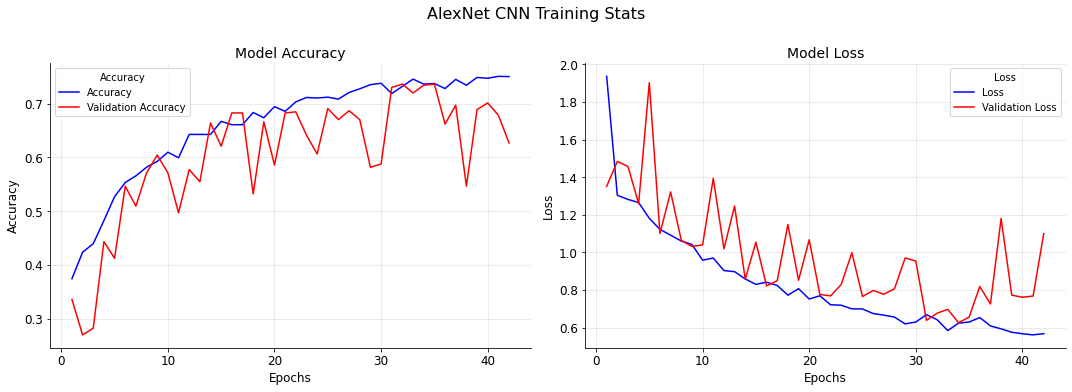

In [ ]:
training_process_viz(pd.DataFrame(alexnet_train_history.history), plot_title = 'AlexNet CNN Training Stats')

#### **8.2.4 Confusion Matrix for AlexNet CNN Model**

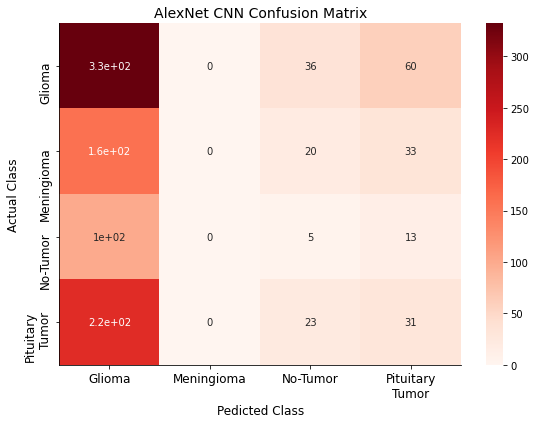

In [ ]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_name else tf.device(cpu_device_location):
    confusion_matrix_viz(alexnet_cnn,
                         test_dataset,
                         plot_title = "AlexNet CNN Confusion Matrix")

In [ ]:
alexnet_report_df = generate_report(alexnet_cnn, test_dataset = test_dataset, row_indexes = ['AlexNet CNN'])
alexnet_report_df

33/33 [==============================] - 33s 988ms/step - loss: 1.1357 - accuracy: 0.6079


,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
AlexNet CNN,1.301541,3.205202,1.790308,1.135692,0.6079,0.382466


### **8.3 Inception V3**

#### **8.3.1 Developement of InceptionV3**

In [ ]:
inception_v3_model = InceptionV3(include_top = False,
                                 input_shape = (image_size, image_size, 3),
                                 pooling = 'avg')
inception_v3_model.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
inception_cnn_model = Sequential()
inception_cnn_model.add(inception_v3_model)
inception_cnn_model.add(Flatten())
inception_cnn_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-1'))
inception_cnn_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
inception_cnn_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
inception_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
Hidden-Layer-1 (Dense)       (None, 1024)              2098176   
_________________________________________________________________
Output-Layer (Dense)         (None, 4)                 4100      
Total params: 23,905,060
Trainable params: 2,102,276
Non-trainable params: 21,802,784
_________________________________________________________________


#### **8.3.2 Training and Validation of InceptionV3 Model**

In [ ]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    inception_model_train_history = inception_cnn_model.fit(train_dataset,
                                                            batch_size = batch_size,
                                                            validation_data = validation_dataset,
                                                            epochs = 100,
                                                            callbacks = [early_stopping, inceptionv3_cp_callback])

Epoch 1/100
61/61 [==============================] - 83s 1s/step - loss: 1.8779 - accuracy: 0.6012 - val_loss: 0.7379 - val_accuracy: 0.7113

Epoch 00001: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/InceptionV3
Epoch 2/100
61/61 [==============================] - 76s 1s/step - loss: 0.6863 - accuracy: 0.7335 - val_loss: 0.6218 - val_accuracy: 0.7979

Epoch 00002: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/InceptionV3
Epoch 3/100
61/61 [==============================] - 76s 1s/step - loss: 0.6144 - accuracy: 0.7670 - val_loss: 0.6042 - val_accuracy: 0.7835

Epoch 00003: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/InceptionV3
Epoch 4/100
61/61 [==============================] - 76s 1s/step - loss: 0.5593 - accuracy: 0.7774 - val_loss: 0.8480 - val_accuracy: 0.6536

Epoch 00004: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/InceptionV3
Epoch 5/100
61/61 [=

#### **8.3.3 InceptionV3 Model Training Process Statistics**

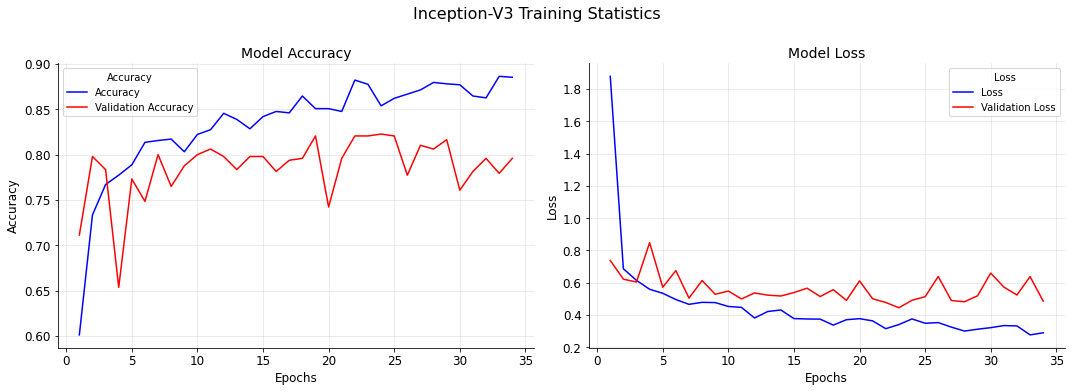

In [ ]:
training_process_viz(pd.DataFrame(inception_model_train_history.history),
                     plot_title = 'Inception-V3 Training Statistics')

#### **8.3.4 Confusion Matrix for InceptionV3 Model**

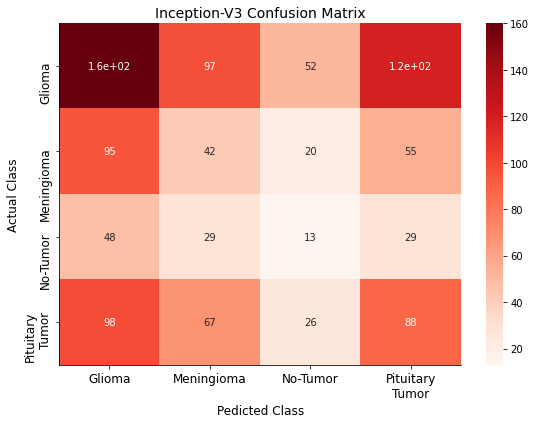

In [ ]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_name):
    confusion_matrix_viz(inception_cnn_model,
                         test_dataset,
                         plot_title = "Inception-V3 Confusion Matrix")

In [ ]:
inceptionv3_report_df = generate_report(inception_cnn_model, test_dataset = test_dataset, row_indexes = ['InceptionV3'])
inceptionv3_report_df

33/33 [==============================] - 32s 962ms/step - loss: 0.4522 - accuracy: 0.8256


,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
InceptionV3,1.365125,3.101156,1.76101,0.452249,0.825626,0.2842


## **9. Conclusions**

* The **pre-trained (imagenet) InceptionV3** model has performed the best among Multi-Layer perceptron and AlexNet CNN models with an accuracy of $82.57\%$ (Refer the following table).

In [ ]:
final_report_df = pd.concat([mlp_report_df, alexnet_report_df, inceptionv3_report_df])
final_report_df

,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
Multi-Layer-Perceptron Model,1.394990,3.533719,1.879819,0.926313,0.624277,0.368979
AlexNet CNN,1.301541,3.205202,1.790308,1.135692,0.607900,0.382466
InceptionV3,1.365125,3.101156,1.761010,0.452249,0.825626,0.284200


## **10. Future Works**  

* To incorporate a Data Augmentation pipeline to efficiently generate various different variants of the iamges to make the model more roboust.  

* Training process will be migrated to TPUs (Tensor Processing Units) by representing the data in TFRecord format for significant reduction in training time.  

* Implementation of R-CNN to not only detect a image which has a tumor in it but to also label the location of the tumor in the image.  
